### Examining Telemarketing Data
 
Please see <code>db.py</code> and <code>processing.py</code> for the implentation of database and processing related utilities used in this notebook.

In [1]:
from db import Database
import processing as proc
from pathlib import Path
import time
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsClassifier
import sklearn
import pickle

logger = proc.setupLog()
figureCount = 0
records = Database('bank_data')


### Taking a look
We begin by checking the frequency of the target, <code>y</code>, which denotes whether or not a purchase was made.
We can see that our data is imbalaced, with about nine examples with <code>y=0</code> to each one <code>y=1</code>.

There are two seperate datasets here, both have the same target, with one having a few extra features, they are primarily economic indicators at the time of contact.  The datasets were taken from UCI's machine learning repository linked [here](http://archive.ics.uci.edu/ml/datasets/Bank+Marketing).




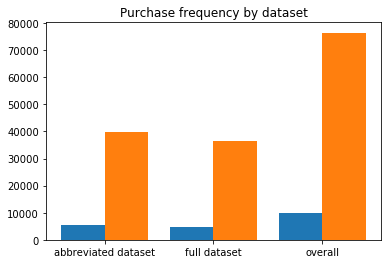

In the abbreviated dataset a purchase occured 11.70% of the time.
In the full dataset a purchase occured 11.27% of the time.
In the combined dataset a purchase occured 11.49% of the time.


In [2]:
numPeople = records.getSize('people')
numPeopleA = records.getSize('people_additional')
results = records.getEntriesByField('people',0,numPeople,'y')
resultsA = records.getEntriesByField('people_additional',0,numPeopleA,'y')
##tally up number of Y/N s
peopleBuy = 0
for char in results:
    if char == 'Y': peopleBuy+=1
peopleBuyA = 0
for char in resultsA:
    if char == 'Y': peopleBuyA+=1

buys = (peopleBuy,peopleBuyA,peopleBuy+peopleBuyA)
notBuys = (numPeople-buys[0],numPeopleA-buys[1],numPeople+numPeopleA-buys[2])

##Plot
ind = [ i for i in range(len(buys)) ]
width = .4
plt.figure(figureCount)
figureCount+=1
plt.bar(ind,buys,width,label= 'Purchase')
plt.bar([item+width for item in ind],notBuys,width,label='No Purchase')
plt.title('Purchase frequency by dataset')
plt.xticks([item+width/2 for item in ind],('abbreviated dataset','full dataset', 'overall'))
plt.show()

print("In the abbreviated dataset a purchase occured {:.2f}% of the time.".format(
     ( float(buys[0])/float(numPeople) )*100 ) )
print("In the full dataset a purchase occured {:.2f}% of the time.".format(
     ( float(buys[1])/float(numPeopleA) )*100 ) )
print("In the combined dataset a purchase occured {:.2f}% of the time.".format(
     ( float(buys[2])/float(numPeople+numPeopleA) )*100 ) )

### Getting our dataset ready for processing
The dataset has been extracted from csv, translated for efficient storage (strings mapped to characters etc.) and loaded into a MySQL database.
Below is a few of the fetched SQL entries and human-readable dataframes lines.  For completeness, a single final encoding of the ready-for-work numpy vector is also displayed.
*Note: We remove the <code>duration</code> field as reccomended in the dataset posting.  See the link above for more information.*



In [3]:
#get data dictionaries for processing
peopleMap, peopleAdditionalMap = records.getMaps()

#sql entries
line = records.getEntries('people',0,numPeople)

print('First 5 of the sql entries:')
for i in range(5):
    print(line[i])
    
#translate to human-readable dataframe (similar to original csv)
df = proc.getDataFrame(line,peopleMap)
print('\n\nHead of the dataframe:')
print(df.head())

#see validate for more details, basically ensures all categories accounted for properly
proc.validate(df,peopleMap)
vec = proc.getOneHot(df,peopleMap,False)

#duration is not known until outcome is known
#see dataset documentation for more info
vec = vec.drop('duration',axis=1)
dataOneHot = vec.to_numpy(dtype=np.float64)

print('\n\nFinally, here is a single vector ready for processing:')
print(dataOneHot[0])


#do the same as above for tha additional dataset
lineA = records.getEntries('people_additional',0,numPeopleA)
dfa = proc.getDataFrame(lineA,peopleAdditionalMap)
proc.validate(dfa,peopleAdditionalMap)
vecA = proc.getOneHot(dfa,peopleAdditionalMap,False)
vecA = vecA.drop('duration',axis=1)
dataOneHotA = vecA.to_numpy(dtype=np.float64)

#get column labels
colTitles = vec.columns
colTitlesA = vecA.columns

#rand generator
randomGenr = np.random.default_rng()

First 5 of the sql entries:
(58, 'M', 'M', 'T', 'N', 2143, 'Y', 'N', '?', 5, 5, 261, 1, -1, 0, '?', 'N')
(44, 'T', 'S', 'S', 'N', 29, 'Y', 'N', '?', 5, 5, 151, 1, -1, 0, '?', 'N')
(33, 'E', 'M', 'S', 'N', 2, 'Y', 'Y', '?', 5, 5, 76, 1, -1, 0, '?', 'N')
(47, 'B', 'M', '?', 'N', 1506, 'Y', 'N', '?', 5, 5, 92, 1, -1, 0, '?', 'N')
(33, '?', 'S', '?', 'N', 1, 'N', 'N', '?', 5, 5, 198, 1, -1, 0, '?', 'N')


Head of the dataframe:
   age           job  marital  education isDefault  balance housing loan  \
0   58    management  married   tertiary        no     2143     yes   no   
1   44    technician   single  secondary        no       29     yes   no   
2   33  entrepreneur  married  secondary        no        2     yes  yes   
3   47   blue-collar  married    unknown        no     1506     yes   no   
4   33       unknown   single    unknown        no        1      no   no   

   contact  day  month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5      5       261        

### Getting organized

Here the datasets and models are generated and setup.<br>
The data is processed in its raw form, and also after scaling it with 

[<code>sklearn.preprocessing.StandardScaler</code>](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)<br>

The followind models are then run on both sets:<br>

[<code>sklearn.neighbors.KNeighborsClassifier</code>](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)<br>
[<code>sklearn.ensemble.RandomForestClassifier</code>](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)<br>
[<code>sklearn.neural_network.MLPClassifier</code>](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)<br>

In [4]:
numTrees = 1 #rafo trees
maxIter = 1 #for MLP
k = 9 #neighbors for knn


#initialize models
rafo = RandomForestClassifier(n_estimators=numTrees,class_weight='balanced')
rafoA = RandomForestClassifier(n_estimators=numTrees,class_weight='balanced')
mlp = MLPClassifier(max_iter=maxIter)
mlpA = MLPClassifier(max_iter=maxIter)
knn = KNeighborsClassifier(k)
knnA = KNeighborsClassifier(k)

models = { 'RAFO': (rafo,rafoA),#random forest
          'MLP' : (mlp,mlpA),   #multi level perceptron
          'KNN': (knn,knnA)     #k nearest neighbor
         }

#initialize models
rafoS = RandomForestClassifier(n_estimators=numTrees,class_weight='balanced')
rafoAS = RandomForestClassifier(n_estimators=numTrees,class_weight='balanced')
mlpS = MLPClassifier(max_iter=maxIter)
mlpAS = MLPClassifier(max_iter=maxIter)
knnS = KNeighborsClassifier(k)
knnAS = KNeighborsClassifier(k)

modelsScaled = { 'RAFO': (rafoS,rafoAS),#random forest
                 'MLP' : (mlpS,mlpAS),  #multi level perceptron
                 'KNN' : (knnS,knnAS)   #k nearest neighbor
                } 



### Running the model
The models are run and relavent information stored.

In [5]:
accumulator = []
results = {key:dict({ke:None for ke in ['probabilities','predictions']}) for key in models.keys()}
resultsScaled = {key:dict({ke:None for ke in ['probabilities','predictions']}) for key in modelsScaled.keys()}
totalIterations = 1
testLabels = [None for _ in range(totalIterations)]
testLabelsA = [None for _ in range(totalIterations)]
for i in range(totalIterations):
    randomGenr.shuffle(dataOneHot)
    randomGenr.shuffle(dataOneHotA)
    #extract features, set float
    features = dataOneHot[:,:-1].astype(np.float64)
    featuresA = dataOneHotA[:,:-1].astype(np.float64)
    #extract labels
    labels = dataOneHot[:,-1]
    labelsA = dataOneHotA[:,-1]    
    #get ~20% of indices as random choice WITHOUT replacement for test
    testIndices = randomGenr.choice(len(labels),size=int(len(labels)*.2),replace=False)
    testIndicesA = randomGenr.choice(len(labelsA),size=int(len(labelsA)*.2),replace=False)
    #take test items
    
    testLabels[i] = np.take(labels,testIndices)
    testFeatures = np.take(features,testIndices,axis=0)
    testLabelsA[i] = np.take(labelsA,testIndicesA)
    testFeaturesA = np.take(featuresA,testIndicesA,axis=0)
    
    #remove test items
    trainLabels = np.delete(labels,testIndices)
    trainFeatures = np.delete(features,testIndices,axis=0)
    trainLabelsA = np.delete(labelsA,testIndicesA)
    trainFeaturesA = np.delete(featuresA,testIndicesA,axis=0)
    
    #create scaled features
    scaler = sklearn.preprocessing.StandardScaler()
    trainFeaturesS = scaler.fit_transform(trainFeatures)
    testFeaturesS = scaler.fit_transform(testFeatures)
    trainFeaturesAS = scaler.fit_transform(trainFeaturesA)
    testFeaturesAS = scaler.fit_transform(testFeaturesA)
    
    print('trial: {}'.format(i))
    for name,model,modelS in zip(models.keys(),models.values(),modelsScaled.values()):
        model[0].fit(trainFeatures,trainLabels)
        model[1].fit(trainFeaturesA,trainLabelsA)
        modelS[0].fit(trainFeaturesS,trainLabels)
        modelS[1].fit(trainFeaturesAS,trainLabelsA)
    
        #get predictions
        preds = model[0].predict(testFeatures)
        predsA = model[1].predict(testFeaturesA)
        predsS = modelS[0].predict(testFeaturesS)
        predsAS = modelS[1].predict(testFeaturesAS)
        results[name]['predictions'] = [preds,predsA]
        resultsScaled[name]['predictions'] = [predsS,predsAS]
    
        #get P(y=1) for each prediction
        probs = [pair[1] for pair in model[0].predict_proba(testFeatures)]
        probsA = [pair[1] for pair in model[1].predict_proba(testFeaturesA)]
        probsS = [pair[1] for pair in modelS[0].predict_proba(testFeaturesS)]
        probsAS = [pair[1] for pair in modelS[1].predict_proba(testFeaturesAS)]
        results[name]['probabilities'] = (probs,probsA)
        resultsScaled[name]['probabilities'] = (probsS,probsAS)
        accumulator.append([results,resultsScaled])
    
    

trial: 10
trial: 10
trial: 10
trial: 10
trial: 10
trial: 10
trial: 10
trial: 10
trial: 10
trial: 10


### Tallying up results
Finally, we tally the information.

In [6]:
tallys = {key:np.empty((2,2,2,0),dtype='float64').tolist() for key in models.keys()}
tallysS = {key:np.empty((2,2,2,0),dtype='float64').tolist() for key in modelsScaled.keys()}
for entry,tLabels,tLabelsA in zip(accumulator,testLabels,testLabelsA):
    for key in results.keys():
        results = entry[0]
        resultsScaled = entry[1]
        #SETUP FOR THIS:
        #tallys[modelName][0=firstDataSet,1=AdditionalDataSet][trueLabel][predictedLabel] = [list of P(y_{model}=1)]
        j=0
        for labels,predictions,predictionsS in zip([tLabels,tLabelsA],results[key]['predictions'],resultsScaled[key]['predictions']):
            i=0
            for test,pred,predS in zip(labels,predictions,predictionsS):
                    tallys[key][j][int(test)][int(predS)].append(results[key]['probabilities'][j][i])
                    tallysS[key][j][int(test)][int(predS)].append(resultsScaled[key]['probabilities'][j][i])
                    i+=1
            j+=1


### Checking error rates

 
We can see that the best performing model on the abbreviated feature data is Random Forest, while K Nearest Neighbors performed best on the full featured dataset.  Scaling the data is not helpful in either case. 

[0.14238000442380006, 0.15739880557398805, 0.1431984074319841]
[0.1332116788321168, 0.14730148197301482, 0.13082282680822827]
[0.15629476751244384, 0.17278135243413864, 0.1571931528469103]
[0.14623042369794828, 0.1616972198616001, 0.14360810974869492]


<Figure size 2880x2880 with 0 Axes>

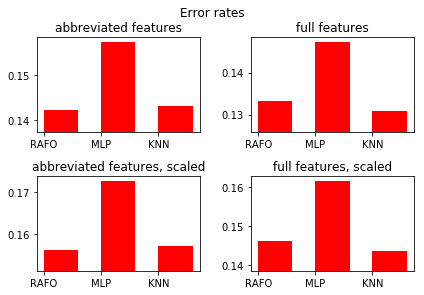

RAFO is Random Forest
MLP is Multi Level Perceptron
KNN is K Nearest Neighbors


In [7]:
#Plot raw error rates of each model
ind = [ i for i in range(len(models)) ]
width = .6
plt.figure(figureCount,figsize=(40,40))
fig, ax = plt.subplots(2, 2)

titles = ['abbreviated features','full features'],['abbreviated features, scaled','full features, scaled']
tally = [tallys,tallysS]
totals = [sum([len(testLabels[i]) for i in range(totalIterations)]),sum([len(testLabelsA[i]) for i in range(totalIterations)])]
figureCount+=1
for i in range(2):
    for j in range (2):
        wrong = [(len(tally[i][key][j][1][0])+len(tally[i][key][j][0][1]))/totals[i] for key in tallys.keys()]
        print(wrong)
        #set bottom for each graph
        bottom = min(wrong)-.005
        ax[i,j].bar([item+width for item in ind],[item-bottom for item in wrong],width,label='Incorrect Predictions',color='red',bottom=bottom)
        ax[i,j].set_xticks([item+width/2 for item in ind])
        ax[i,j].set_xticklabels(tallys.keys())
        ax[i,j].set_title(titles[i][j])
plt.tight_layout()
plt.suptitle('Error rates',verticalalignment='baseline')
plt.show()
print('RAFO is Random Forest\nMLP is Multi Level Perceptron\nKNN is K Nearest Neighbors')

While ~90% success rate is not terrible on a balanced dataset.  We know that our dataset is biased, and so this prediction success rate is about equal to the error rate obtained by guessing randomly according to the distribution of classes.  Moving forward, we'll only work with the non-scaled data since the scaling wasn't helpful.

### Slightly modifying our metric
Lets define some things, first.<br>
Define a test set:
$$   D^{test} = \{ ( x_{i} ,y_{i}) \mid 0 \leq i \lt N \}  $$
    Where there are N examples in a dataset with feature vector x, label y

Define the previously learned *estimator* $ f_{\theta}(\cdot) $, parameterized by $\theta$:
$$ f_{\theta}(x_{i}) = \hat{y} \approx y_{i} $$
and let
$$ P_{\theta}(y_{i}=1\mid x_{i}) = p_{i} $$
for a given test example $( x_{i} ,y_{i})$<br><br>
and finally we define the *indicator* $ I_{i} $: <br><br>
$$ I_{i} = 1 \iff   y_{i}=1 \:  $$<br>
$$ else \: \: \: I_{i} = 0 $$

and now define a sorted list:
$$ \mathcal{S} = \{  s^{j} = (s_{p}^{j},s_{I}^{j}) = ( p_{i} ,I_{i}) \mid 0 \leq i,j \lt N \: , \: a \gt b \implies s_{p}^{a} \gt s_{p}^{b} \} $$ 

In English: $\mathcal{S}$ is a list of indicator-probabilty pairs (like a priority queue) sorted in increasing order by probabilities.<br><br>
Now,
$$ \mathcal{S}_{t} = \{ s^{j} \mid 0 \leq j \lt floor(\frac{t}{100})(N) \: , \: 1 \leq t \leq 100 \} $$

In English: $\mathcal{S}_{t}$ is the first "$t \%$"  of $\mathcal{S}$.

Lastly we will define,
$$ S(t)  =   \frac{\sum_{j \leq \mid \mathcal{S}_{t}\mid} s_{p}^{j}}{\sum_{j \leq \mid \mathcal{S}\mid} s_{p}^{j}} $$

In English: $ S(t) $ is the percentage of true positives inside $\mathcal{S}_{t}$.
$ S(t) $ essentially describes the percentage of <code>y=1</code> labeled test samples in the top $t\%$ of the model's probability ranking.


We'll now make some plots of $S(t)$ for each model dataset pair. 

<Figure size 432x288 with 0 Axes>

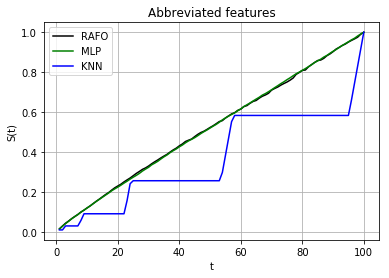

<Figure size 432x288 with 0 Axes>

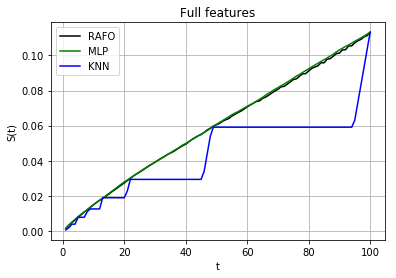

In [8]:
#tallys[modelName][0=firstDataSet,1=AdditionalDataSet][trueLabel][predictedLabel] = [list of P(y_{model}=1)]
#array to study
s = {key:[None,None] for key in tallys.keys()}
points ={key: [None,None] for key in tallys.keys()}
totals = [sum([sum(testLabels[i]) for i in range(totalIterations)]),sum([len(testLabelsA[i]) for i in range(totalIterations)])]
##TODO:: SOMEHOW THE NUMBER OF TRUE POSITIVES IS DIFFERENT PER MODEL, THIS SHOULD NOT BE THE CASE
for key in tallys.keys():
    for i in range(2):
        #take true positives out, most important
        positives = np.append([tp for tp in tallys[key][i][1][1]],[fn for fn in tallys[key][i][1][0]])
        #take count of totals while convenient
        #take false positives, true negatives OUT
        others = np.append([tn for tn in tallys[key][i][0][0]],[fp for fp in tallys[key][i][0][1]])
        #add true positives to S
        positives = [ (1,prob) for prob in positives ]
        others = [ (0,prob) for prob in others ]
        #get final array
        s[key][i] = sorted(np.concatenate((others,positives)),key=lambda key_value: key_value[1],reverse=True)
        points[key][i] = [(t,proc.S(s[key][i],t,totals[i])) for t in range(1,101)]
        #generate points for graphing
for i in range(2):
    #genrate set of 100 points, t S(t) pairs for each model/dataset pair
    plt.figure(figureCount)
    figureCount+=1
    fig, ax = plt.subplots()
    for key,color in zip(points.keys(),['black','green','blue']):
        ax.plot([point[0] for point in points[key][i]],[point[1] for point in points[key][i]],color,label=key)
        ax.set(xlabel='t', ylabel='S(t)',title=('Full features' if i==1 else 'Abbreviated features'))
    ax.grid()
    ax.legend()
    fig.savefig("S(t)_{}_{}.png".format(key,i))
    plt.show()


### Taking a look inside

Finally, lets take a look at the factors involved in making these predictions for the Random Forest model.

Values which yield negative importance set to zero.
(['month - -6.2946%', 'job - -0.0000%', 'marital - -0.0000%', 'education - -0.0000%', 'isDefault - -0.0000%', 'housing - -0.0000%', 'loan - -0.0000%', 'contact - -0.0000%', 'poutcome - -0.0000%', 'day - 0.0000%', 'balance - 13.5626%', 'campaign - 15.5094%', 'age - 23.2317%', 'previous - 24.7891%', 'pdays - 29.2018%', 'other - 0.0000%'], [-6.29461388708609, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 1.9543095240740888e-13, 13.562621674237526, 15.509409474367308, 23.231667748215358, 24.789097988319092, 29.201817001946612, 0], [])


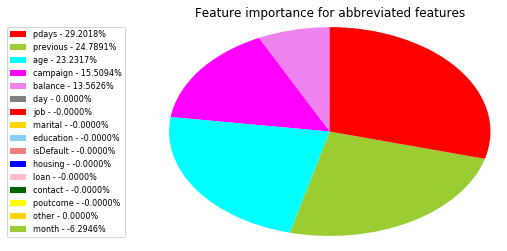

other feautures :
Values which yield negative importance set to zero.
(['job - -0.0000%', 'marital - -0.0000%', 'education - -0.0000%', 'isDefault - -0.0000%', 'housing - -0.0000%', 'loan - -0.0000%', 'contact - -0.0000%', 'poutcome - -0.0000%', 'previous - 1.0316%', 'campaign - 4.2835%', 'age - 4.6423%', 'pdays - 5.1133%', 'day_of_week - 5.1805%', 'cons.price.idx - 6.7055%', 'month - 7.3671%', 'cons.conf.idx - 7.7372%', 'emp.var.rate - 12.6934%', 'nr.employed - 20.2512%', 'euribor3m - 24.9944%', 'other - 0.0000%'], [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 1.0316214397846963, 4.283471630410431, 4.642296479031175, 5.113254092845934, 5.1805337519623285, 6.705539358600579, 7.367122673245118, 7.737160798385285, 12.693429019959627, 20.251177394034535, 24.99439336174029, 0], [])


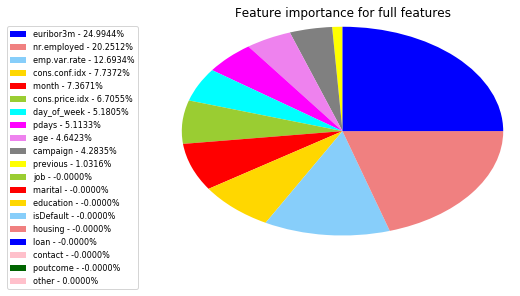

other feautures :


In [11]:
labels = [testLabels[0],testLabelsA[0]]
features = [testFeatures,testFeaturesA]
cols = [colTitles,colTitlesA]
maps = [peopleMap,peopleAdditionalMap]
titles =['Feature importance for abbreviated features','Feature importance for full features']
for i in range(2):
    importances = permutation_importance(models['RAFO'][i],features[i],labels[i],n_repeats=10)['importances_mean']
    result = proc.processImportance(maps[i],cols[i],importances)
    print(result)
    proc.pie(result[0],result[1],result[2],titles[i],figureCount)
    figureCount+=1

### *Discussion*

1) Initial prediciton scores

2) S(t) graphs

3) Random Forest feature Importance

4) Hypothetical next steps
<br>


Thank you to the authors of [Moro et al., 2014](https://core.ac.uk/download/pdf/55631291.pdf) for the dataset and inspiration.